<a ><img src="http://innovator.com.ua/wp-content/uploads/2019/03/shutterstock_503122378-840x525.jpg" width="400" align="center"></a>

<h1><center>Anomaly Detection in IoT sensors using machine learning</center></h1>


<h4>About this Notebook</h4>
This notebook is created to detect anomaly in IoT sensors. Over many steps below we can define which algorithm is the most suitable in this situation.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

1. [Understanding data](#0)<br>
2. [Data visualization and pre-processing](#2)<br>
3. [Classification](#4) <br>
      . [K Neareast Neighbors](#6) <br>
      . [Decision Tree](#8) <br>
      . [Logistic Regression](#10) <br>
      . [Random Forest](#14) <br>
      . [Neural Network](#16) <br>
4. [Model Evaluation](#12) <br> 
5. [Report](#18) <br> 
</div>
<hr>

### Importing Needed packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

##pd.set_option('display.max_column', 50)

In [2]:
#!conda install -c anaconda seaborn -y


<h1 id="understanding_data">1. Understanding the Data</h1> <a id="0"></a>

### `mainSimulationAccessTraces.csv`:  
We have downloaded a DS2OS traffic traces dataset, **`mainSimulationAccessTraces.csv`**, which contains traces captures in the IoT environment DS2OS.[Dataset source](https://www.kaggle.com/francoisxa/ds2ostraffictraces)

##   Import Data

In [3]:
#data = pd.read_csv('mainSimulationAccessTraces.csv')
#data.shape

In [4]:
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_aefa0132d2b14df5a0e73c7c8923d2af = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='adPQ1kIXWCJO-iF_Td-zji4Y16TTVq251ywXemFZ4CW2',
    ibm_auth_endpoint="https://iam.ng.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_aefa0132d2b14df5a0e73c7c8923d2af.get_object(Bucket='anomalydetectioniniotsensors-donotdelete-pr-uttlkb2u28atlz',Key='mainSimulationAccessTraces.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

data = pd.read_csv(body)
data.head()


,sourceID,sourceAddress,sourceType,sourceLocation,destinationServiceAddress,destinationServiceType,destinationLocation,accessedNodeAddress,accessedNodeType,operation,value,timestamp,normality
0,lightcontrol2,/agent2/lightcontrol2,/lightControler,BedroomParents,/agent2/lightcontrol2,/lightControler,BedroomParents,/agent2/lightcontrol2,/lightControler,registerService,none,1520031600000,normal
1,lightcontrol3,/agent3/lightcontrol3,/lightControler,Dinningroom,/agent3/lightcontrol3,/lightControler,Dinningroom,/agent3/lightcontrol3,/lightControler,registerService,none,1520031603269,normal
2,lightcontrol1,/agent1/lightcontrol1,/lightControler,BedroomChildren,/agent1/lightcontrol1,/lightControler,BedroomChildren,/agent1/lightcontrol1,/lightControler,registerService,none,1520031603279,normal
3,lightcontrol4,/agent4/lightcontrol4,/lightControler,Kitchen,/agent4/lightcontrol4,/lightControler,Kitchen,/agent4/lightcontrol4,/lightControler,registerService,none,1520031603290,normal
4,movement4,/agent4/movement4,/movementSensor,Kitchen,/agent4/movement4,/movementSensor,Kitchen,/agent4/movement4,/movementSensor,registerService,none,1520031603464,normal


Lets first have a descriptive exploration on our data.


In [5]:
data.columns.values.tolist()


['sourceID',
 'sourceAddress',
 'sourceType',
 'sourceLocation',
 'destinationServiceAddress',
 'destinationServiceType',
 'destinationLocation',
 'accessedNodeAddress',
 'accessedNodeType',
 'operation',
 'value',
 'timestamp',
 'normality']

===> There are 13 columns in the dataset.

Let’s see how many of each class is in our data set.


In [6]:
data['normality'].value_counts()

normal                           347935
anomalous(DoSattack)               5780
anomalous(scan)                    1547
anomalous(malitiousControl)         889
anomalous(malitiousOperation)       805
anomalous(spying)                   532
anomalous(dataProbing)              342
anomalous(wrongSetUp)               122
Name: normality, dtype: int64

==> There are 347935 normal traces, and other 7 types anomalous traces.

# 2. Data visualization and pre-processing <a id="2"></a>

###### Check if any null value in the dataset.

In [7]:
data.isnull().sum()

sourceID                        0
sourceAddress                   0
sourceType                      0
sourceLocation                  0
destinationServiceAddress       0
destinationServiceType          0
destinationLocation             0
accessedNodeAddress             0
accessedNodeType              148
operation                       0
value                        2050
timestamp                       0
normality                       0
dtype: int64

“Accessed Node Type” feature has 148 rows containing ‘NaN’ value, so we will replace NaN value with the 'Malicious' value.


In [8]:
data.accessedNodeType.unique()

array(['/lightControler', '/movementSensor', '/sensorService',
       '/derived/boolean', '/basic/number', '/batteryService',
       '/doorLockService', '/thermostat', '/washingService',
       '/basic/text', '/smartPhone', nan, '/basic/composed'], dtype=object)

In [9]:
data.accessedNodeType = data['accessedNodeType'].fillna(value='Malicious')

######  Check continuous values in "Value" column

In [10]:
pd.to_numeric(data['value'], errors='coerce')


0                  NaN
1                  NaN
2                  NaN
3                  NaN
4                  NaN
5                  NaN
6                  NaN
7                  NaN
8                  NaN
9                  NaN
10                 NaN
11                 NaN
12                 NaN
13                 NaN
14                 NaN
15        2.004640e+01
16        1.000000e+00
17                 NaN
18                 NaN
19        1.521217e+12
20                 NaN
21                 NaN
22        1.983910e+01
23        1.990880e+01
24                 NaN
25                 NaN
26        1.995230e+01
27                 NaN
28                 NaN
29                 NaN
              ...     
357922    1.971750e+01
357923    1.000000e+00
357924    2.005750e+01
357925    1.984200e+01
357926    0.000000e+00
357927    1.000000e+00
357928    2.017720e+01
357929    1.000000e+01
357930    2.009500e+01
357931    1.000000e+00
357932    1.000000e+00
357933    1.990910e+01
357934     

Replace unexpected value

In [11]:
df2 = data.replace({'value': {'false': 0.0, 'true': 1.0, 'twenty': 20.0, 'none': 0.0}})

In [12]:
df2.value = df2['value'].fillna(value=0.0)

In [13]:
pd.to_numeric(df2['value'], errors='coerce').tolist()


[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 20.0464,
 1.0,
 0.0,
 0.0,
 1521216755210.0,
 0.0,
 0.0,
 19.8391,
 19.9088,
 0.0,
 0.0,
 19.9523,
 0.0,
 0.0,
 0.0,
 1.0,
 1521216758314.0,
 19.8185,
 20.0005,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 1.0,
 0.0,
 1.0,
 0.0,
 20.475,
 20.2078,
 1.0,
 0.0,
 20.1757,
 19.7536,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 19.7719,
 20.4103,
 1.0,
 0.0,
 0.0,
 19.8609,
 20.1794,
 1.0,
 0.0,
 0.0,
 20.0372,
 20.1058,
 19.7941,
 1.0,
 0.0,
 0.0,
 19.9142,
 0.0,
 20.3042,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 20.1346,
 1.0,
 19.7922,
 20.1731,
 0.0,
 20.1458,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 19.7587,
 20.1929,
 0.0,
 20.4331,
 1.0,
 0.0,
 19.6966,
 19.6209,
 0.0,
 19.9143,
 1.0,
 0.0,
 1.0,
 0.0,
 0.0,
 19.6963,
 1.0,
 0.0,
 19.5072,
 0.0,
 20.4032,
 1521216770002.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 1.0,
 0.0,
 19.986,
 20.2714,
 20.3664,
 0.0,
 19.6491,
 19.6007,
 0.0,
 1.0,
 0.0,
 0.0,
 19.7861,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 20.

In [14]:
pd.to_numeric(df2['value'], errors='coerce').value_counts()

0.000000e+00    78674
1.000000e+00    71507
1.000000e+01     9635
5.000000e+00     8487
2.000000e+00     8438
6.000000e+00     8435
4.000000e+00     8435
7.000000e+00     8428
9.000000e+00     8428
3.000000e+00     8427
8.000000e+00     8427
1.988190e+01     2017
2.000000e+01      219
3.240000e+00      176
1.994970e+01      129
5.100000e+00      117
1.988100e+01       51
2.026210e+01       33
2.040570e+01       33
2.032550e+01       33
2.031890e+01       31
2.029810e+01       31
1.964820e+01       31
1.982160e+01       31
2.019090e+01       30
2.021560e+01       30
2.048420e+01       30
2.007220e+01       29
2.011090e+01       29
1.959720e+01       29
                ...  
1.521221e+12        1
1.521218e+12        1
1.521217e+12        1
1.521223e+12        1
1.521218e+12        1
1.521221e+12        1
1.521222e+12        1
1.521225e+12        1
1.521222e+12        1
1.521221e+12        1
1.521223e+12        1
1.521218e+12        1
1.521224e+12        1
1.521219e+12        1
1.521220e+

In [15]:
pd.to_numeric(df2['value'], errors='coerce').isnull()

0         False
1         False
2         False
3         False
4         False
5         False
6         False
7         False
8         False
9         False
10        False
11        False
12        False
13        False
14        False
15        False
16        False
17        False
18        False
19        False
20        False
21        False
22        False
23        False
24        False
25        False
26        False
27        False
28        False
29        False
          ...  
357922    False
357923    False
357924    False
357925    False
357926    False
357927    False
357928    False
357929    False
357930    False
357931    False
357932    False
357933    False
357934    False
357935    False
357936    False
357937    False
357938    False
357939    False
357940    False
357941    False
357942    False
357943    False
357944    False
357945    False
357946    False
357947    False
357948    False
357949    False
357950    False
357951    False
Name: value, Length: 357

In [16]:
df3 = df2[pd.to_numeric(df2['value'], errors='coerce').isnull()]

In [17]:
df3

,sourceID,sourceAddress,sourceType,sourceLocation,destinationServiceAddress,destinationServiceType,destinationLocation,accessedNodeAddress,accessedNodeType,operation,value,timestamp,normality
358,doorlock3,/agent12/doorlock3,/doorLockService,Entrance,/agent12/doorlock3,/doorLockService,Entrance,/agent12/doorlock3/open,/basic/text,subscribe,org.ds2os.vsl.core.utils.AddressParameters@463...,1520032077873,normal
359,doorlock5,/agent21/doorlock5,/doorLockService,room_2,/agent21/doorlock5,/doorLockService,room_2,/agent21/doorlock5/open,/basic/text,subscribe,org.ds2os.vsl.core.utils.AddressParameters@699...,1520032077873,normal
362,doorlock4,/agent20/doorlock4,/doorLockService,room_1,/agent20/doorlock4,/doorLockService,room_1,/agent20/doorlock4/open,/basic/text,subscribe,org.ds2os.vsl.core.utils.AddressParameters@273...,1520032078847,normal
373,doorlock2,/agent10/doorlock2,/doorLockService,Livingroom,/agent10/doorlock2,/doorLockService,Livingroom,/agent10/doorlock2/open,/basic/text,subscribe,org.ds2os.vsl.core.utils.AddressParameters@181...,1520032082004,normal
384,battery4,/agent11/battery4,/batteryService,Watterroom,/agent11/battery4,/batteryService,Watterroom,/agent11/battery4/charge,/basic/number,subscribe,org.ds2os.vsl.core.utils.AddressParameters@5c4...,1520032087098,normal
401,doorlock1,/agent3/doorlock1,/doorLockService,Dinningroom,/agent3/doorlock1,/doorLockService,Dinningroom,/agent3/doorlock1/open,/basic/text,subscribe,org.ds2os.vsl.core.utils.AddressParameters@687...,1520032095760,normal
404,battery1,/agent5/battery1,/batteryService,Garage,/agent5/battery1,/batteryService,Garage,/agent5/battery1/charge,/basic/number,subscribe,org.ds2os.vsl.core.utils.AddressParameters@4ff...,1520032096610,normal
412,battery5,/agent12/battery5,/batteryService,Entrance,/agent12/battery5,/batteryService,Entrance,/agent12/battery5/charge,/basic/number,subscribe,org.ds2os.vsl.core.utils.AddressParameters@3eb...,1520032098865,normal
454,battery6,/agent12/battery6,/batteryService,Entrance,/agent12/battery6,/batteryService,Entrance,/agent12/battery6/charge,/basic/number,subscribe,org.ds2os.vsl.core.utils.AddressParameters@2c8...,1520032113205,normal
459,battery3,/agent4/battery3,/batteryService,Kitchen,/agent4/battery3,/batteryService,Kitchen,/agent4/battery3/charge,/basic/number,subscribe,org.ds2os.vsl.core.utils.AddressParameters@61b...,1520032113769,normal


###### Remove all the rows with unexpected values 

In [18]:
data2 = df2.drop(df2.index[df3.index])

In [19]:
data2.isnull().sum()

sourceID                     0
sourceAddress                0
sourceType                   0
sourceLocation               0
destinationServiceAddress    0
destinationServiceType       0
destinationLocation          0
accessedNodeAddress          0
accessedNodeType             0
operation                    0
value                        0
timestamp                    0
normality                    0
dtype: int64

###### Remove " Timestamp" 

In [20]:
data2 = data2.drop('timestamp',axis=1)

In [21]:
data2

,sourceID,sourceAddress,sourceType,sourceLocation,destinationServiceAddress,destinationServiceType,destinationLocation,accessedNodeAddress,accessedNodeType,operation,value,normality
0,lightcontrol2,/agent2/lightcontrol2,/lightControler,BedroomParents,/agent2/lightcontrol2,/lightControler,BedroomParents,/agent2/lightcontrol2,/lightControler,registerService,0,normal
1,lightcontrol3,/agent3/lightcontrol3,/lightControler,Dinningroom,/agent3/lightcontrol3,/lightControler,Dinningroom,/agent3/lightcontrol3,/lightControler,registerService,0,normal
2,lightcontrol1,/agent1/lightcontrol1,/lightControler,BedroomChildren,/agent1/lightcontrol1,/lightControler,BedroomChildren,/agent1/lightcontrol1,/lightControler,registerService,0,normal
3,lightcontrol4,/agent4/lightcontrol4,/lightControler,Kitchen,/agent4/lightcontrol4,/lightControler,Kitchen,/agent4/lightcontrol4,/lightControler,registerService,0,normal
4,movement4,/agent4/movement4,/movementSensor,Kitchen,/agent4/movement4,/movementSensor,Kitchen,/agent4/movement4,/movementSensor,registerService,0,normal
5,tempin2,/agent2/tempin2,/sensorService,BedroomParents,/agent2/tempin2,/sensorService,BedroomParents,/agent2/tempin2,/sensorService,registerService,0,normal
6,movement2,/agent2/movement2,/movementSensor,BedroomParents,/agent2/movement2,/movementSensor,BedroomParents,/agent2/movement2,/movementSensor,registerService,0,normal
7,tempin4,/agent4/tempin4,/sensorService,Kitchen,/agent4/tempin4,/sensorService,Kitchen,/agent4/tempin4,/sensorService,registerService,0,normal
8,tempin1,/agent1/tempin1,/sensorService,BedroomChildren,/agent1/tempin1,/sensorService,BedroomChildren,/agent1/tempin1,/sensorService,registerService,0,normal
9,movement1,/agent1/movement1,/movementSensor,BedroomChildren,/agent1/movement1,/movementSensor,BedroomChildren,/agent1/movement1,/movementSensor,registerService,0,normal


###### Lets plot some columns to understand data better:

Text(0, 0.5, 'Frequency')

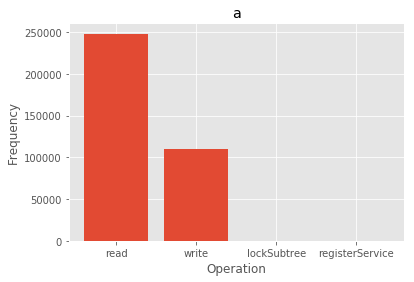

In [22]:
# create a figure and axis 
fig, ax = plt.subplots() 
# count the occurrence of each class 
data_operation = data2['operation'].value_counts() 
# get x and y data 
operation = data_operation.index 
frequency = data_operation.values
# create bar chart 
ax.bar(operation, frequency) 
# set title and labels 
ax.set_title('a') 
ax.set_xlabel('Operation') 
ax.set_ylabel('Frequency')

([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text xticklabel objects>)

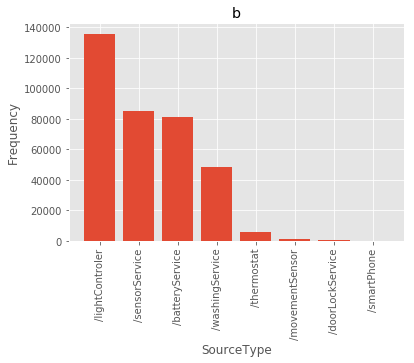

In [23]:
fig, ax = plt.subplots() 
data_st = data2['sourceType'].value_counts() 
st = data_st.index 
frequency = data_st.values
ax.bar(st, frequency) 
ax.set_title('b') 
ax.set_xlabel('SourceType') 
ax.set_ylabel('Frequency')
plt.xticks( fontsize=10, rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text xticklabel objects>)

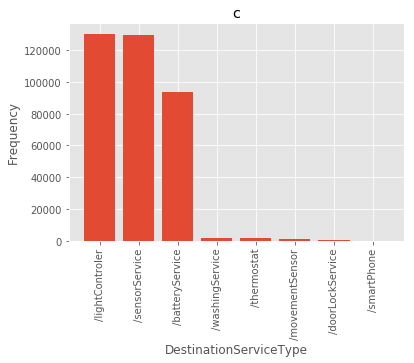

In [24]:
fig, ax = plt.subplots() 
data_dt = data2['destinationServiceType'].value_counts() 
dt = data_st.index 
frequency = data_dt.values
ax.bar(dt, frequency) 
ax.set_title('c') 
ax.set_xlabel('DestinationServiceType') 
ax.set_ylabel('Frequency')
plt.xticks( fontsize=10, rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 <a list of 21 Text xticklabel objects>)

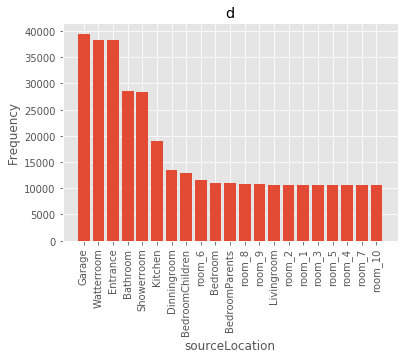

In [25]:
fig, ax = plt.subplots() 
data_sl = data2['sourceLocation'].value_counts() 
sl = data_sl.index 
frequency = data_sl.values
ax.bar(sl, frequency) 
ax.set_title('d') 
ax.set_xlabel('sourceLocation') 
ax.set_ylabel('Frequency')
plt.xticks( fontsize=10, rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
 <a list of 21 Text xticklabel objects>)

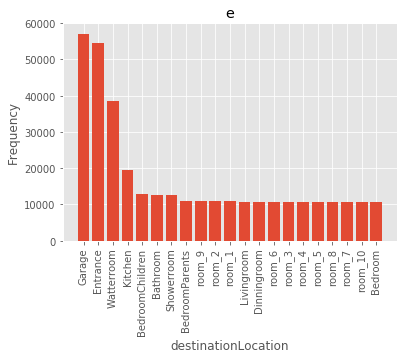

In [72]:
fig, ax = plt.subplots() 
data_dl = data2['destinationLocation'].value_counts() 
dl = data_dl.index 
frequency = data_dl.values
ax.bar(dl, frequency) 
ax.set_title('e') 
ax.set_xlabel('destinationLocation') 
ax.set_ylabel('Frequency')
plt.xticks( fontsize=10, rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 <a list of 13 Text xticklabel objects>)

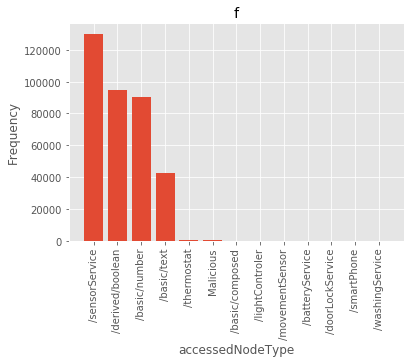

In [27]:
fig, ax = plt.subplots() 
data_ant = data2['accessedNodeType'].value_counts() 
ant = data_ant.index 
frequency = data_ant.values
ax.bar(ant, frequency) 
ax.set_title('f') 
ax.set_xlabel('accessedNodeType') 
ax.set_ylabel('Frequency')
plt.xticks( fontsize=10, rotation=90)

#####  LABEL ENCODING

In [28]:
data2.normality.unique()

array(['normal', 'anomalous(scan)', 'anomalous(malitiousOperation)',
       'anomalous(DoSattack)', 'anomalous(spying)',
       'anomalous(dataProbing)', 'anomalous(wrongSetUp)',
       'anomalous(malitiousControl)'], dtype=object)

In [29]:
df = data2

In [30]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df["accessedNodeType_code"]= le.fit_transform(df["accessedNodeType"])
df["sourceID_code"]= le.fit_transform(df["sourceID"])
df["sourceAddress_code"]= le.fit_transform(df["sourceAddress"])
df["sourceType_code"]= le.fit_transform(df["sourceType"])
df["sourceLocation_code"]= le.fit_transform(df["sourceLocation"])
df["destinationServiceAddress_code"]= le.fit_transform(df["destinationServiceAddress"])
df["destinationServiceType_code"]= le.fit_transform(df["destinationServiceType"])
df["destinationLocation_code"]= le.fit_transform(df["destinationLocation"])
df["accessedNodeAddress_code"]= le.fit_transform(df["accessedNodeAddress"])
df["operation_code"]= le.fit_transform(df["operation"])
df["normality_code"]= le.fit_transform(df["normality"])

In [31]:
numeric_cols = ['timestamp','value']
categorical_cols = list(set(data.columns.values.tolist()) - set(numeric_cols))
df = df.drop(columns = categorical_cols)

In [32]:
df['value'] = df.value.astype(float)

In [33]:
df.dtypes

value                             float64
accessedNodeType_code               int64
sourceID_code                       int64
sourceAddress_code                  int64
sourceType_code                     int64
sourceLocation_code                 int64
destinationServiceAddress_code      int64
destinationServiceType_code         int64
destinationLocation_code            int64
accessedNodeAddress_code            int64
operation_code                      int64
normality_code                      int64
dtype: object

In [34]:
df.normality_code.unique()

array([7, 4, 3, 0, 5, 1, 6, 2])

In [35]:
list(le.inverse_transform(df.normality_code.unique()))

['normal',
 'anomalous(scan)',
 'anomalous(malitiousOperation)',
 'anomalous(DoSattack)',
 'anomalous(spying)',
 'anomalous(dataProbing)',
 'anomalous(wrongSetUp)',
 'anomalous(malitiousControl)']

##### Split Data

In [36]:
X = df.drop('normality_code', axis = 1 )
y = df.normality_code

In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

##### Scaling

In [38]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:5: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:6: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


# 3. Classification <a id="4"></a>

<h2><center>K Nearest Neighbor(KNN)</center></h2>

#### Building the KNN models by assigning the value of K from 1 to 10 <a id="6"></a>

In [39]:
# Importing the KNN model
from sklearn.neighbors import KNeighborsClassifier

# Importing the metrics
from sklearn import metrics

Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    y_predict=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_predict)

    
    std_acc[n-1]=np.std(y_predict==y_test)/np.sqrt(y_predict.shape[0])

mean_acc

array([0.99346265, 0.99346265, 0.99432871, 0.99346265, 0.99432871,
       0.99346265, 0.99432871, 0.99429146, 0.9942449 ])

#### Plot model accuracy for different number of Neighbors

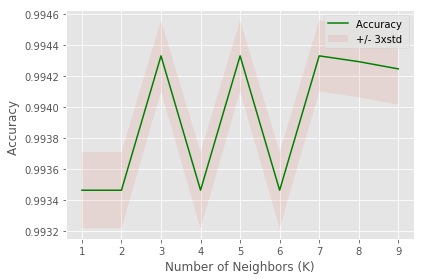

In [40]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [41]:
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.9943287112485216 with k= 3


### Build the KNN model with k = 3 

This code is used to calculate the time processing

In [42]:
import time

_start_time = time.time()

def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [43]:
# Set value of k as 3
k = 3

# Train Model 
knn = KNeighborsClassifier(n_neighbors = k).fit(X_train,y_train)


### Save model to string using pickle

In [44]:
import pickle 
  
# Save the trained model as a pickle string. 
saved_model = pickle.dumps(knn) 
  
# Load the pickled model 
knn_from_pickle = pickle.loads(saved_model) 

In [45]:
# Use the loaded pickled model to make predictions 
 
tic()
y_predict_knn = knn_from_pickle.predict(X_test)
y_predict_knn[0:5]
tac()

Time passed: 0hour:0min:20sec


In [46]:
from __future__ import print_function
import numpy as np 

def acc(y_test, y_pred):
    correct = np.sum(y_test == y_pred)
    return float(correct)/y_test.shape[0]

print('accuracy = ', acc(y_test, y_predict_knn))

accuracy =  0.9943287112485216


<h2><center>Decision Tree</center></h2><a id="8"></a>

In [47]:
# Import the decision tree model

from sklearn.tree import DecisionTreeClassifier

#### Decision Tree Modelling

- Build the decision tree model
- Train the model with different max depth ranging from 1 to 10
- Calculate the accuracy of each model

In [48]:
md = 10
mean_acc = np.zeros((md-1))
std_acc = np.zeros((md-1))
ConfustionMx = [];
for n in range(1,md):
    
    #Train Model and Predict  
    DT = DecisionTreeClassifier(criterion="entropy", max_depth = n).fit(X_train,y_train)
    y_predict=DT.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_predict)

    
    std_acc[n-1]=np.std(y_predict==y_test)/np.sqrt(y_predict.shape[0])

mean_acc

array([0.97191362, 0.97191362, 0.98059283, 0.98553775, 0.98907648,
       0.99183297, 0.99256866, 0.99410521, 0.99410521])

#### Plot model accuracy for different number of max depth

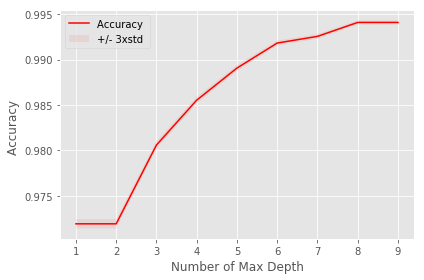

In [49]:
plt.plot(range(1,md),mean_acc,'r')
plt.fill_between(range(1,md),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Max Depth')
plt.tight_layout()
plt.show()

### Building the decision tree with max depth of 8

In [50]:

T = DecisionTreeClassifier(criterion="gini", max_depth = 8)

# Check the default parameters
DT 

# Train the Decision tree model
DT.fit(X_train,y_train)



DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=9,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Save model to string using pickle

In [51]:
import pickle 
  
# Save the trained model as a pickle string. 
saved_model_dt = pickle.dumps(DT) 
  
# Load the pickled model 
dt_from_pickle = pickle.loads(saved_model_dt) 

In [52]:
tic()
# Predict using the model
y_predict_dt= dt_from_pickle.predict(X_test)
tac()

Time passed: 0hour:0min:0sec


<h2><center>Logictic Regression</center></h2><a id="10"></a>

#### Identifying which solver in the logistic regresion has the highes accuracy

In [53]:
# Import the library for Logistice regression
from sklearn.linear_model import LogisticRegression

# Build and train the logestic regression model
lr1 = LogisticRegression(C=0.01, solver='liblinear').fit(X_train,y_train)
yhat1 = lr1.predict(X_test)
lr_a1 = metrics.accuracy_score(y_test, yhat1)

# Build and train the logestic regression model
lr2 = LogisticRegression(C=0.01, solver='sag').fit(X_train,y_train)
yhat2 = lr2.predict(X_test)
lr_a2 = metrics.accuracy_score(y_test, yhat2)

# Build and train the logestic regression model
lr3 = LogisticRegression(C=0.01, solver='saga').fit(X_train,y_train)
yhat3 = lr3.predict(X_test)
lr_a3 = metrics.accuracy_score(y_test, yhat3)

# Build and train the logestic regression model
lr4 = LogisticRegression(C=0.01, solver='newton-cg').fit(X_train,y_train)
yhat4 = lr4.predict(X_test)
lr_a4 = metrics.accuracy_score(y_test, yhat4)

# Build and train the logestic regression model
lr5 = LogisticRegression(C=0.01, solver='lbfgs').fit(X_train,y_train)
yhat5 = lr5.predict(X_test)
lr_a5 = metrics.accuracy_score(y_test, yhat5)


print('LR model with liblinear solver',lr_a1)
print('LR model with sag solver',lr_a2)
print('LR model with saga solver',lr_a3)
print('LR model with newton-cg solver',lr_a4)
print('LR model with lbfgs solver',lr_a5)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarni

LR model with liblinear solver 0.9817662013540318
LR model with sag solver 0.9826881349934348
LR model with saga solver 0.9826881349934348
LR model with newton-cg solver 0.9826881349934348
LR model with lbfgs solver 0.9826881349934348


In [54]:
# Find if labels are missing in the models 
print("The label missing in the LR model with liblinear solver",set(y_test) - set(yhat1))
print("The label missing in the LR model with sag solver",set(y_test) - set(yhat2))
print("The label missing in the LR model with saga solver",set(y_test) - set(yhat3))
print("The label missing in the LR model with newton-cg solver",set(y_test) - set(yhat4))
print("The label missing in the LR model with lbfgs solver",set(y_test) - set(yhat5))

The label missing in the LR model with liblinear solver {1, 2, 3, 4, 5, 6}
The label missing in the LR model with sag solver {1, 2, 4, 5, 6}
The label missing in the LR model with saga solver {1, 2, 4, 5, 6}
The label missing in the LR model with newton-cg solver {1, 2, 4, 5, 6}
The label missing in the LR model with lbfgs solver {1, 2, 4, 5, 6}


====> Hence, the best logistic classifier will be the one with a lbfgs solver.

### Save model to string using pickle

In [55]:
import pickle 
lr = LogisticRegression( solver='lbfgs').fit(X_train,y_train)

# Save the trained model as a pickle string. 
saved_model_lr = pickle.dumps(lr) 
  
# Load the pickled model 
lr_from_pickle = pickle.loads(saved_model_lr) 

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


In [56]:
tic()
# Predict using the model
y_predict_lr= lr_from_pickle.predict(X_test)
tac()

Time passed: 0hour:0min:0sec


<h2><center>Random Forest</center></h2><a id="14"></a>

### Save model to string using pickle

In [57]:
import pickle 
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion="gini",random_state=0,n_estimators=100)
rf.fit(X_train, y_train.values.ravel())

# Save the trained model as a pickle string. 
saved_model_rf = pickle.dumps(rf) 
  
# Load the pickled model 
rf_from_pickle = pickle.loads(saved_model_rf) 

In [58]:
tic()
y_predict_rf = rf_from_pickle.predict(X_test)
tac()

Time passed: 0hour:0min:2sec


<h2><center>Artificial Neural Network</center></h2><a id="16"></a>

### Save model to string using pickle

In [59]:
import pickle 
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)
mlp.fit(X_train, y_train.values.ravel())

# Save the trained model as a pickle string. 
saved_model_mlp = pickle.dumps(mlp) 
  
# Load the pickled model 
mlp_from_pickle = pickle.loads(saved_model_mlp)

In [60]:
tic()
y_predict_mlp = mlp_from_pickle.predict(X_test)
tac()

Time passed: 0hour:0min:0sec


# 4. Model Evaluation<a id="12"></a>

### Building the confusion matrix 

1. KNN

In [61]:
from sklearn.metrics import confusion_matrix,classification_report
cnf_matrix = confusion_matrix(y_test, y_predict_knn)
print(cnf_matrix)
print(classification_report(y_test,y_predict_knn))
print("Train set Accuracy: ", metrics.accuracy_score(y_train, knn_from_pickle.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_predict_knn))

[[  1122      0      0      0      0      0      0    607]
 [     0    122      0      0      0      0      0      0]
 [     0      0    269      0      0      0      0      0]
 [     0      0      0    233      0      0      0      0]
 [     0      0      0      0    465      0      0      0]
 [     0      0      0      0      0    165      0      0]
 [     0      0      0      0      0      0     33      0]
 [     0      0      0      0      1      1      0 104365]]
              precision    recall  f1-score   support

           0       1.00      0.65      0.79      1729
           1       1.00      1.00      1.00       122
           2       1.00      1.00      1.00       269
           3       1.00      1.00      1.00       233
           4       1.00      1.00      1.00       465
           5       0.99      1.00      1.00       165
           6       1.00      1.00      1.00        33
           7       0.99      1.00      1.00    104367

   micro avg       0.99      0.99      

2. Decision Tree

In [62]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_predict_dt)
print(confusion_matrix)
print (classification_report(y_test, y_predict_dt))
print("Train set Accuracy: ", metrics.accuracy_score(y_train, dt_from_pickle.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_predict_dt))


[[  1122      0      0      0      0      0      0    607]
 [     0    122      0      0      0      0      0      0]
 [     0      0    269      0      0      0      0      0]
 [     0      0      0    233      0      0      0      0]
 [     0      0      0      0    465      0      0      0]
 [     0      0      0      0      0    165      0      0]
 [     0      0      0      0      0      0     33      0]
 [    26      0      0      0      0      0      0 104341]]
              precision    recall  f1-score   support

           0       0.98      0.65      0.78      1729
           1       1.00      1.00      1.00       122
           2       1.00      1.00      1.00       269
           3       1.00      1.00      1.00       233
           4       1.00      1.00      1.00       465
           5       1.00      1.00      1.00       165
           6       1.00      1.00      1.00        33
           7       0.99      1.00      1.00    104367

   micro avg       0.99      0.99      

3. Logistic Regression

In [63]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_predict_lr)
print(confusion_matrix)
print (classification_report(y_test, y_predict_lr))
print("Train set Accuracy: ", metrics.accuracy_score(y_train, lr_from_pickle.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_predict_lr))

[[  1122      0      0      0      0      0      0    607]
 [     0      0      0      0      0      0      0    122]
 [     0      0      0      0      0      0      0    269]
 [     0      0      0    115      0      0      0    118]
 [     0      0      2      0      0      0      0    463]
 [     0      0      0      0      0      0      0    165]
 [     0      0      0      0      0      0      0     33]
 [    42      0      0     21      0      0      0 104304]]
              precision    recall  f1-score   support

           0       0.96      0.65      0.78      1729
           1       0.00      0.00      0.00       122
           2       0.00      0.00      0.00       269
           3       0.85      0.49      0.62       233
           4       0.00      0.00      0.00       465
           5       0.00      0.00      0.00       165
           6       0.00      0.00      0.00        33
           7       0.98      1.00      0.99    104367

   micro avg       0.98      0.98      

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


4. Random Forest

In [64]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_predict_rf)
print(confusion_matrix)
print (classification_report(y_test, y_predict_rf))
print("Train set Accuracy: ", metrics.accuracy_score(y_train, rf_from_pickle.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_predict_rf))

[[  1122      0      0      0      0      0      0    607]
 [     0    122      0      0      0      0      0      0]
 [     0      0    269      0      0      0      0      0]
 [     0      0      0    233      0      0      0      0]
 [     0      0      0      0    465      0      0      0]
 [     0      0      0      0      0    165      0      0]
 [     0      0      0      0      0      0     33      0]
 [    26      0      0      0      0      0      0 104341]]
              precision    recall  f1-score   support

           0       0.98      0.65      0.78      1729
           1       1.00      1.00      1.00       122
           2       1.00      1.00      1.00       269
           3       1.00      1.00      1.00       233
           4       1.00      1.00      1.00       465
           5       1.00      1.00      1.00       165
           6       1.00      1.00      1.00        33
           7       0.99      1.00      1.00    104367

   micro avg       0.99      0.99      

5. Neural Network

In [65]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_predict_mlp)
print(confusion_matrix)
print (classification_report(y_test, y_predict_mlp))
print("Train set Accuracy: ", metrics.accuracy_score(y_train, mlp_from_pickle.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, y_predict_mlp))

[[  1122      0      0      0      0      0      0    607]
 [     0    122      0      0      0      0      0      0]
 [     0      0    269      0      0      0      0      0]
 [     0      0      0    233      0      0      0      0]
 [     0      0      0      0    465      0      0      0]
 [     0      0      0      0      0    165      0      0]
 [     0      0      0      0      0      0     33      0]
 [    26      0      0      0      5      1      0 104335]]
              precision    recall  f1-score   support

           0       0.98      0.65      0.78      1729
           1       1.00      1.00      1.00       122
           2       1.00      1.00      1.00       269
           3       1.00      1.00      1.00       233
           4       0.99      1.00      0.99       465
           5       0.99      1.00      1.00       165
           6       1.00      1.00      1.00        33
           7       0.99      1.00      1.00    104367

   micro avg       0.99      0.99      

### Plot ROC Curve


1. KNN

Automatically created module for IPython interactive environment


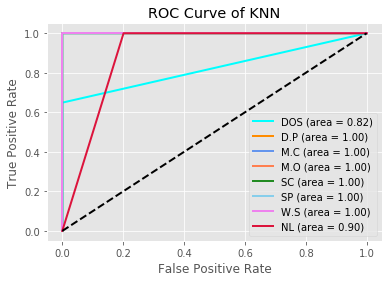

In [66]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

classes = [0,1,2,3,4,5,6,7]
n_classes = 8

fpr = dict()
tpr = dict()
roc_auc = dict()
# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(y_predict_knn))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 2

classname = ['DOS', 'D.P','M.C','M.O','SC','SP','W.S','NL']

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'coral', 'forestgreen', 'skyblue', 'violet', 'crimson'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label= classname[i]  + ' (area = {1:0.2f})'
             ''.format(i, roc_auc[i]) )


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of KNN')
plt.legend(loc="lower right")
plt.show()

2. Decision Tree

Automatically created module for IPython interactive environment


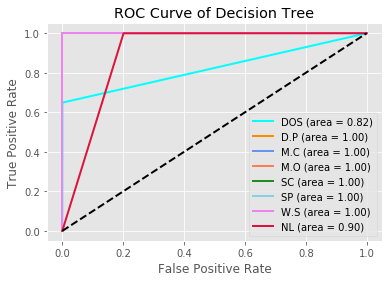

In [67]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

classes = [0,1,2,3,4,5,6,7]
n_classes = 8

fpr2 = dict()
tpr2 = dict()
roc_auc2 = dict()
# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr2[i], tpr2[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(y_predict_dt))[:, i])
    roc_auc2[i] = auc(fpr2[i], tpr2[i])
    
# First aggregate all false positive rates
all_fpr2 = np.unique(np.concatenate([fpr2[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr2 = np.zeros_like(all_fpr2)
for i in range(n_classes):
    mean_tpr2 += interp(all_fpr2, fpr2[i], tpr2[i])

# Finally average it and compute AUC
mean_tpr2 /= n_classes

fpr2["macro"] = all_fpr2
tpr2["macro"] = mean_tpr2
roc_auc2["macro"] = auc(fpr2["macro"], tpr2["macro"])

# Plot all ROC curves
lw = 2

classname = ['DOS', 'D.P','M.C','M.O','SC','SP','W.S','NL']

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'coral', 'forestgreen', 'skyblue', 'violet', 'crimson'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr2[i], tpr2[i], color=color, lw=lw,
             label= classname[i]  + ' (area = {1:0.2f})'
             ''.format(i, roc_auc2[i]) )


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Decision Tree')
plt.legend(loc="lower right")
plt.show()

3. Logistic Regression

Automatically created module for IPython interactive environment


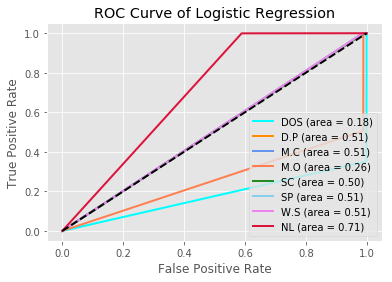

In [68]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

classes = [0,1,2,3,4,5,6,7]
n_classes = 8

fpr3 = dict()
tpr3 = dict()
roc_auc3 = dict()
# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr3[i], tpr3[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], y_predict_lr)
    roc_auc3[i] = auc(fpr3[i], tpr3[i])
    
# First aggregate all false positive rates
all_fpr3 = np.unique(np.concatenate([fpr3[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr3 = np.zeros_like(all_fpr3)
for i in range(n_classes):
    mean_tpr3 += interp(all_fpr3, fpr3[i], tpr3[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr3["macro"] = all_fpr3
tpr3["macro"] = mean_tpr3
roc_auc3["macro"] = auc(fpr3["macro"], tpr3["macro"])

# Plot all ROC curves
lw = 2

classname = ['DOS', 'D.P','M.C','M.O','SC','SP','W.S','NL']

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'coral', 'forestgreen', 'skyblue', 'violet', 'crimson'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr3[i], tpr3[i], color=color, lw=lw,
             label= classname[i]  + ' (area = {1:0.2f})'
             ''.format(i, roc_auc3[i]) )


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Logistic Regression')
plt.legend(loc="lower right")
plt.show()

4. Random Forest

Automatically created module for IPython interactive environment


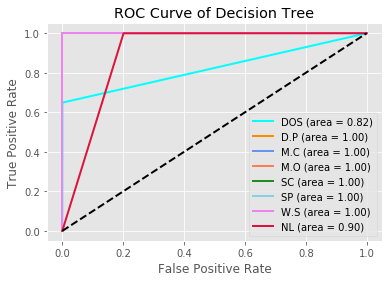

In [69]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

classes = [0,1,2,3,4,5,6,7]
n_classes = 8

fpr4 = dict()
tpr4 = dict()
roc_auc4 = dict()
# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr4[i], tpr4[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(y_predict_rf))[:, i])
    roc_auc4[i] = auc(fpr4[i], tpr4[i])
    
# First aggregate all false positive rates
all_fpr4 = np.unique(np.concatenate([fpr4[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr4 = np.zeros_like(all_fpr4)
for i in range(n_classes):
    mean_tpr4 += interp(all_fpr4, fpr4[i], tpr4[i])

# Finally average it and compute AUC
mean_tpr4 /= n_classes

fpr4["macro"] = all_fpr4
tpr4["macro"] = mean_tpr4
roc_auc4["macro"] = auc(fpr4["macro"], tpr4["macro"])

# Plot all ROC curves
lw = 2

classname = ['DOS', 'D.P','M.C','M.O','SC','SP','W.S','NL']

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'coral', 'forestgreen', 'skyblue', 'violet', 'crimson'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr4[i], tpr4[i], color=color, lw=lw,
             label= classname[i]  + ' (area = {1:0.2f})'
             ''.format(i, roc_auc4[i]) )


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of Decision Tree')
plt.legend(loc="lower right")
plt.show()

5. Neural Network

Automatically created module for IPython interactive environment


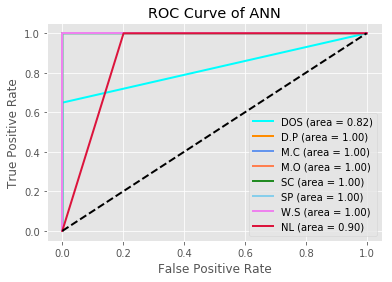

In [70]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

classes = [0,1,2,3,4,5,6,7]
n_classes = 8

fpr5 = dict()
tpr5 = dict()
roc_auc5 = dict()
# Compute ROC curve and ROC area for each class
for i in range(n_classes):
    fpr5[i], tpr5[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(y_predict_mlp))[:, i])
    roc_auc5[i] = auc(fpr5[i], tpr5[i])
    
# First aggregate all false positive rates
all_fpr5 = np.unique(np.concatenate([fpr5[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr5 = np.zeros_like(all_fpr5)
for i in range(n_classes):
    mean_tpr5 += interp(all_fpr5, fpr5[i], tpr5[i])

# Finally average it and compute AUC
mean_tpr5 /= n_classes

fpr5["macro"] = all_fpr5
tpr5["macro"] = mean_tpr5
roc_auc5["macro"] = auc(fpr5["macro"], tpr5["macro"])

# Plot all ROC curves
lw = 2

classname = ['DOS', 'D.P','M.C','M.O','SC','SP','W.S','NL']

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'coral', 'forestgreen', 'skyblue', 'violet', 'crimson'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr5[i], tpr5[i], color=color, lw=lw,
             label= classname[i]  + ' (area = {1:0.2f})'
             ''.format(i, roc_auc5[i]) )


plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of ANN')
plt.legend(loc="lower right")
plt.show()

# 5. Report <a id="18"></a>

| Algorithm                   | Accuracy | Precision | Recall  | F1 Score |
|-----------------------------|--------- |---------- |---------|----------|
| KNN                         | 0.9942   | 0.99      | 0.99    | 0.99     |  
| DecisionTree                | 0.9941   | 0.99      | 0.99    | 0.99     |
| LogisticRegression          | 0.9828   | 0.98      | 0.98    | 0.98     | 
| RandomForest                | 0.9941   | 0.99      | 0.99    | 0.99     |
| ArtificialNeuralNetwork     | 0.9940   | 0.99      | 0.99    | 0.99     |

==> KNN has the highest accuracy. Therefore I choose KNN to use in my project.